In [44]:
import time
import requests
from io import BytesIO
from PIL import Image
from bs4 import BeautifulSoup
from urllib.parse import urljoin
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from dotenv import load_dotenv
import requests
import os
import re
import matplotlib.pyplot as plt
import json

load_dotenv()
api_key = os.getenv("DEEPSEEK_API_KEY")

# Importar librerias de websracpping

In [2]:
def extraer_info(url):
    options = Options()
    options.add_argument("--headless")  # Ejecutar en modo headless para que no se aprecie la ventana
    options.add_argument("--disable-gpu")
    options.add_argument("--no-sandbox")
    options.add_argument("--disable-dev-shm-usage")

    service = Service()  # Crear el servicio para el controlador
    driver = webdriver.Chrome(service=service, options=options)  # Iniciar el navegador con opciones
    driver.get(url)
    time.sleep(5)  # Espera a que cargue la página y JS

    soup = BeautifulSoup(driver.page_source, 'html.parser')
    driver.quit()

    titles = []
    descriptions = []
    image_urls = []
    gif_urls = []

    # Extraer todos los títulos y subtítulos (h1 a h6)
    for heading in soup.find_all(['h1', 'h2', 'h3', 'h4', 'h5', 'h6']):
        titles.append(heading.get_text(strip=True))

    # Extraer descripciones desde etiquetas <p> o <div>
    for paragraph in soup.find_all('p'):
        text = paragraph.get_text(strip=True)
        if len(text) > 30:  # Filtrar textos cortos
            descriptions.append(text)

    # Extraer imágenes y GIFs
    blacklist_keywords = [
        'logo', 'loggo', 'logotipo', 'favicon', 'icon', 'ico', 'brandmark',
        'marca', 'log_', '_logo', 'log-', '-logo', 'logggo', 'watermark',
        'paypal', 'sistecredito', 'visa', 'mastercard', 'payment', 'pago',
        'credit', 'debit', 'secure', 'checkout', 'cart'
    ]

    for img in soup.find_all('img'):
        src = img.get('src') or img.get('data-src') or img.get('data-image')
        if src:
            full_url = urljoin(url, src)
            full_url_lower = full_url.lower()

            # Excluir imágenes irrelevantes
            if any(keyword in full_url_lower for keyword in blacklist_keywords):
                continue

            # Clasificar imágenes como GIFs o imágenes normales
            if "gif" in full_url_lower:
                gif_urls.append(full_url)
            else:
                image_urls.append(full_url)

    # Eliminar duplicados
    image_urls = list(set(image_urls))
    gif_urls = list(set(gif_urls))

    # Filtrar imágenes por tamaño (opcional, requiere requests y Pillow)
    filtered_image_urls = []
    for img_url in image_urls:
        try:
            response = requests.get(img_url, stream=True, timeout=5)
            if response.status_code == 200:
                img = Image.open(BytesIO(response.content))
                width, height = img.size
                # Excluir imágenes pequeñas (por ejemplo, iconos)
                if width > 100 and height > 100:  # Ajusta el tamaño mínimo según sea necesario
                    filtered_image_urls.append(img_url)
        except Exception:
            continue

    # Agregar todos los títulos como un valor adicional
    todos_los_titulos = titles
    return titles, descriptions, todos_los_titulos, filtered_image_urls, gif_urls

URL: https://judgeme.imgix.net/dyshop/1743735544__254cc32bea812ae361ae969d3306a0a083c4ff7b__original.jpeg?auto=format&w=160


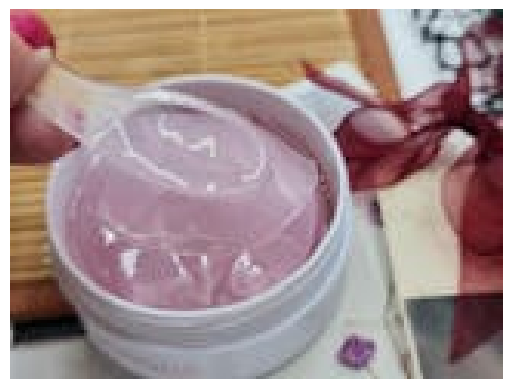

URL: https://judgeme.imgix.net/dyshop/1743735910__935992046c94dc494d33346b40b6281a7df5147e__original.jpeg?auto=format&w=160


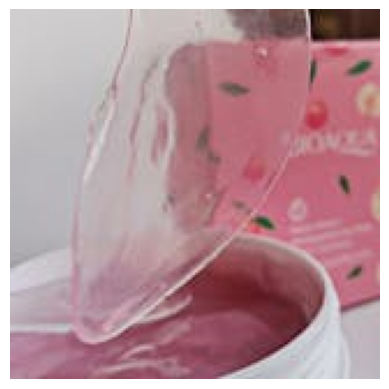

URL: https://dyshopcol.com/cdn/shop/files/Anadir-un-subtitulo-_3.webp?v=1744222993&width=1500


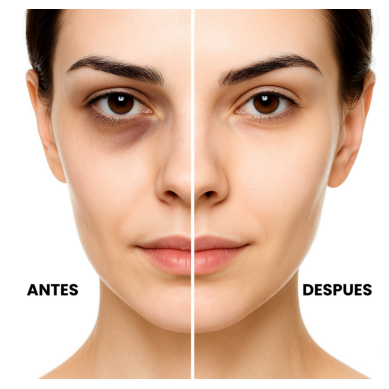

URL: https://dyshopcol.com/cdn/shop/files/472648485_18264_11zon.webp?v=1743711590&width=1500


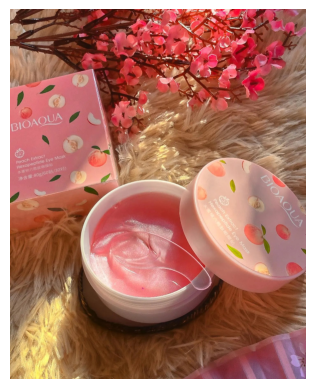

URL: https://judgeme.imgix.net/dyshop/1743735015__523586a13f7f6c3cefd25ff930b22c6dc38e18c0__original.jpeg?auto=format&w=160


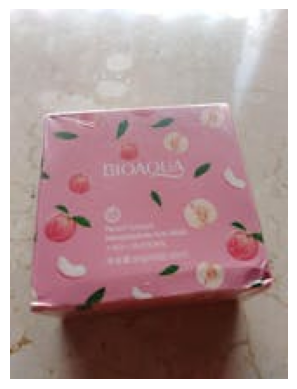

URL: https://judgeme.imgix.net/dyshop/1743735658__cebda50d5c5a91ea3728b84742d85c76132d1f13__original.jpeg?auto=format&w=160


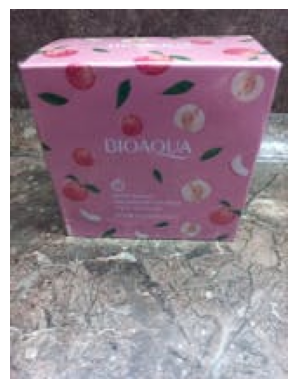

URL: https://judgeme.imgix.net/dyshop/1743735659__f17352a2ab6b361a7c061f57ef48d74eb5014da5__original.jpeg?auto=format&w=160


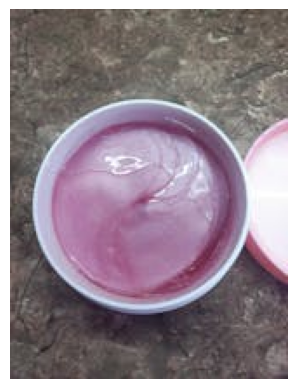

URL: https://judgeme.imgix.net/dyshop/1743735456__capturadepantalla2025-04-03215553__original.png?auto=format&w=160


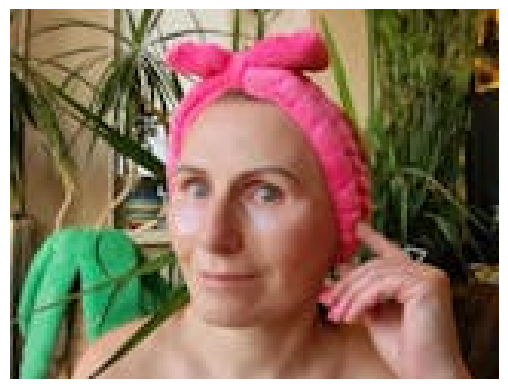

In [3]:
url = "https://dyshopcol.com/products/parches-de-ojos-durazno-bioaqua"
titulo, descripcion, todos_los_titulos, imagenes, gifs = extraer_info(url)


# Mostrar imágenes y URLs
for img_url in imagenes:
    print("URL:", img_url)
    response = requests.get(img_url)
    if response.status_code == 200:
        img = Image.open(BytesIO(response.content))
        plt.imshow(img)
        plt.axis('off')
        plt.show()
    else:
        print(f"Error al cargar la imagen desde {img_url}")

## Agente ia para generar titulos y copies


In [4]:
product_url = input("Ingrese la URL del producto: ").strip()
titulo, descripciones, todos_los_titulos, filtered_image_urls, gif_urls = extraer_info(product_url)

In [7]:
print("Descripciones de productos:", descripciones)
print("Todos los títulos:", todos_los_titulos)
print("URLs de imágenes filtradas:", filtered_image_urls)
print("URLs de GIFs:", gif_urls)

Descripciones de productos: ['ENVÍO GRATIS + PAGO CONTRAENTREGA', 'Desde elprimer usonotarás una sensación de frescura y descongestión.Con uso constante, en pocos días verás unareducción visible de ojeras, bolsitas y arrugas.', '¡Sí! Nuestros parches están formulados coningredientes suaves y naturales, libres de alcohol y parabenos. Son ideales parapiel sensibley pueden usarse a cualquier edad.', '¡Totalmente seguro! Solo pagascuando recibes el producto en tu casa. No necesitas dar datos bancarios.Sin riesgos, sin complicaciones.', 'Precio antes: ̶$̶1̶1̶9̶.̶9̶0̶0̶', 'Cuando pedí la verdad no tenía muchas esperanzas, lo pedí solo por curiosidad, pero la verdad, estoy gratamente sorprendida, los he usado y realmente he obtenido muy buenos resultados, les seguiré comprando!', 'Gracias por tan excelente calidad y por ofrecer la facilidad de pago en casa, excelente producto', 'me llegó hace 2 semanas y los resultados hasta ahora muy buenos!!', 'Me encanta!! ha reducido muchisimo mis lineas 

In [5]:
class AgenteTitulosYCopies:
    def __init__(self):
        load_dotenv()
        self.api_key = os.getenv("DEEPSEEK_API_KEY")
        self.generated_file = "contenido_generado.json"

    def _clean_text(self, text_data):
        """Limpia texto eliminando emojis y caracteres no deseados"""
        if isinstance(text_data, list):
            text_data = " ".join(str(item) for item in text_data if item)
        # Eliminar emojis y caracteres especiales excepto puntuación básica
        text_data = re.sub(r'[^\w\s.,;!?¿¡áéíóúÁÉÍÓÚñÑ-]', '', str(text_data))
        return re.sub(r'\s+', ' ', text_data).strip()

    def _call_ai(self, prompt):
        """Interacción con la API"""
        response = requests.post(
            "https://api.deepseek.com/chat/completions",
            headers={
                "Content-Type": "application/json",
                "Authorization": f"Bearer {self.api_key}"
            },
            json={
                "model": "deepseek-chat",
                "messages": [{
                    "role": "system",
                    "content": "Eres un redactor profesional de contenido comercial, que crea titulos y copies llamativos de venta eres todo un exito y capaz de vender hasta un dulce. No uses emojis ni caracteres especiales."
                }, {
                    "role": "user",
                    "content": prompt
                }],
                "temperature": 0.7
            }
        )
        if response.status_code != 200:
            raise Exception(f"Error de API: {response.status_code} - {response.text}")
        return response.json()["choices"][0]["message"]["content"]

    def generate_results(self, titulo, descripciones):
        """Genera contenido sin mostrar procesos intermedios"""
        # Limpieza de datos
        clean_title = self._clean_text(next((t for t in titulo if t and len(t) > 10), ""))
        clean_desc = self._clean_text(" ".join(d for d in descripciones if d and len(d) > 30))

        if not clean_title or not clean_desc:
            raise ValueError("No se pudo obtener información válida del producto")

        # Generar títulos y copies
        content_prompt = f"""
        Genera 2 títulos publicitarios y 2 copies profesionales, ganadores, llamativos, super redactados como un HUMANO experto en el tema para redes sociales basados en:

        PRODUCTO: {clean_title}
        DESCRIPCIÓN: {clean_desc}

        REQUISITOS:
        - Sin emojis ni caracteres especiales
        - Títulos máximo 50 caracteres
        - Copies de 2-3 frases persuasivas y que tengan los dos minimo 100 caracteres y maximo 248 caracteres
        - No usar palabras como "compra", "adquiere", "obtén" o similares   
        - Lenguaje profesional y orientado a beneficios reales
        - No inventar marcas o nombres comerciales
        - Incluir beneficios clave, ingredientes que tenga el producto y facilidad de pago

        FORMATO EXACTO:
        TITULO 1: [texto]
        TITULO 2: [texto]
        COPY 1: [texto]
        COPY 2: [texto]
        """
        generated_content = self._call_ai(content_prompt)

        # Procesar títulos y copies
        titles = []
        copies = []
        for line in generated_content.split('\n'):
            line = line.strip()
            if line.startswith('TITULO'):
                titles.append(line.split(': ')[1])
            elif line.startswith('COPY'):
                copies.append(line.split(': ')[1])

        # Generar públicos objetivos
        audiences_prompt = f"""
        Genera 5 públicos objetivos numerados (1-5) para este producto:

        PRODUCTO: {clean_title}
        CARACTERÍSTICAS: {clean_desc}

        REQUISITOS:
        - Sin emojis ni caracteres especiales
        - Cada público en una línea numerada
        - Que sea general y una oracion, maximo 20 caracteres
        - Basado en datos demográficos y comportamientos reales
        - Incluir preocupaciones específicas como piel sensible, estrés laboral, etc.
        - Evita hablar de publicos que prefieren pagos contra entrega o evitar datos bancarios, ventas online, etc.
        FORMATO:
        1. Público objetivo 1
        2. Público objetivo 2
        ...
        5. Público objetivo 5
        """
        audiences_response = self._call_ai(audiences_prompt)
        audiences = [re.sub(r'^\d+\.\s*', '', line.strip()) for line in audiences_response.split('\n') if re.match(r'^\d+\.', line.strip())]

        # Guardar resultados
        with open(self.generated_file, 'w', encoding='utf-8') as f:
            json.dump({
                "titulos": titles,
                "copies": copies,
                "publicos_objetivos": audiences
            }, f, ensure_ascii=False, indent=2)

        # Mostrar resultados limpios
        print("\nTITULOS GENERADOS:")
        for i, title in enumerate(titles, 1):
            print(f"{i}. {title}")

        print("\nCOPIES PARA REDES:")
        for i, copy in enumerate(copies, 1):
            print(f"{i}. {copy}")

        print("\nPUBLICOS OBJETIVOS:")
        for i, audience in enumerate(audiences, 1):  
            print(f"{i}. {audience}")

        return titles, copies, audiences


In [6]:
generator = AgenteTitulosYCopies()
generator.generate_results(todos_los_titulos, descripciones)


TITULOS GENERADOS:
1. Descubre el secreto para una mirada rejuvenecida
2. Adios a ojeras y arrugas con resultados visibles

COPIES PARA REDES:
1. Desde la primera aplicación sentirás una frescura incomparable mientras los ingredientes naturales trabajan para reducir bolsas y líneas de expresión. Formulado para pieles sensibles y sin químicos agresivos, es la solución segura que esperabas. Y lo mejor
2. Olvídate de las miradas cansadas con estos parches que combaten ojeras y arrugas con extractos suaves y efectivos. Sin comprometer tu seguridad ni datos bancarios, llegan a tu puerta para que compruebes su poder rejuvenecedor. La comodidad del pago contra entrega hace que probarlos sea una decisión sin riesgos.

PUBLICOS OBJETIVOS:
1. Mujeres 30+ con ojeras marcadas
2. Hombres estresados con bolsas oculares
3. Piel sensible busca solucion natural
4. Adultos con arrugas tempranas ojos
5. Jovenes con falta de sueño visible


(['Descubre el secreto para una mirada rejuvenecida',
  'Adios a ojeras y arrugas con resultados visibles'],
 ['Desde la primera aplicación sentirás una frescura incomparable mientras los ingredientes naturales trabajan para reducir bolsas y líneas de expresión. Formulado para pieles sensibles y sin químicos agresivos, es la solución segura que esperabas. Y lo mejor',
  'Olvídate de las miradas cansadas con estos parches que combaten ojeras y arrugas con extractos suaves y efectivos. Sin comprometer tu seguridad ni datos bancarios, llegan a tu puerta para que compruebes su poder rejuvenecedor. La comodidad del pago contra entrega hace que probarlos sea una decisión sin riesgos.'],
 ['Mujeres 30+ con ojeras marcadas',
  'Hombres estresados con bolsas oculares',
  'Piel sensible busca solucion natural',
  'Adultos con arrugas tempranas ojos',
  'Jovenes con falta de sueño visible'])

## agente ia que generar guiones

In [7]:
class AgenteGuiones:
    def __init__(self):
        load_dotenv()
        self.api_key = os.getenv("DEEPSEEK_API_KEY")
        if not self.api_key:
            raise ValueError("No se encontró la API Key de DeepSeek en el archivo .env")

    def generate_script(self, titulo, descripcion, pais, publico_objetivo, angulo_de_venta, tono, tipo_de_video, duracion):
        prompt = f"""Crea un guión para un {tipo_de_video} de {duracion} segundos que promocione el siguiente producto:
            Título del producto: {titulo}
            Descripción del producto: {descripcion}
            que sera para un el pais de: {pais}
            con un Público objetivo de: {publico_objetivo}
            Ángulo de venta: {angulo_de_venta}
            Tono del video: {tono}

            Devuélveme el guión con la siguiente estructura de ejemplo y las siguientes instrucciones:
            1. No incluyas tiempos ni escenas, solo texto hablado.
            2. “Solo diálogo hablado para video publicitario”.
            3. Solo dame el guion y no tiene que tener encabezado de titulo ni nada, solo el texto.
            4. No incluyas emojis ni caracteres especiales.
            5. No incluyas información adicional, solo el guión.
            
            (Solo es un ejemplo no lo uses en el guion y no lo incluyas en el guion, se creativo y no uses esto como base, solo es un ejemplo de lo que quiero):
            Ejemplo de guión:
            ¿Tu mirada delata el cansancio y el paso del tiempo?
            Descubre los parches que revierten el tiempo en tu mirada.
            Con ingredientes suaves y libres de alcohol, ideales para pieles sensibles.
            Reducen bolsas, ojeras y arrugas desde la primera aplicación.
            Dale a tu piel el cuidado natural y efectivo que merece.
            Y lo mejor: paga solo cuando lo tengas en tus manos, sin riesgos.
            Fácil de usar, resultados visibles.
            Aumenta tu belleza natural sin esfuerzo.
            ¡Pídelos ya y devuélvele la frescura a tu mirada!
            Disponible en todo Colombia.
            """
        messages = [
            {"role": "system", "content": "Eres un guionista experto en videos cortos para publicidad."},
            {"role": "user", "content": prompt}
        ]

        response = requests.post(
            "https://api.deepseek.com/chat/completions",
            headers={
                "Content-Type": "application/json",
                "Authorization": f"Bearer {self.api_key}"
            },
            json={
                "model": "deepseek-chat",
                "messages": messages,
                "temperature": 0.7
            }
        )

        if response.status_code != 200:
            raise Exception(f"Error al llamar la API de DeepSeek: {response.text}")

        return response.json()["choices"][0]["message"]["content"].strip()

In [8]:
import json
# Cargar el contenido del archivo JSON generado
with open("./contenido_generado.json", "r", encoding="utf-8") as file:
    contenido_generado = json.load(file)

# Extraer información relevante del JSON
titulos = contenido_generado.get("titulos", [])
copies = contenido_generado.get("copies", [])
publicos_objetivos = contenido_generado.get("publicos_objetivos", [])

In [9]:
pais = "Colombia"
angulo_de_venta = "Aumenta tu belleza natural"
tono = "Atractivo y coloquial (Medellín)"
tipo_de_video = "video corto para redes sociales"
duracion = 30  # Duración en segundos
print(f"Título: {titulos[0]}")
print(f"Copy: {copies[0]}")
print(f"Público objetivo: {publicos_objetivos[2]}")
print(f"País: {pais}")
print(f"Ángulo de venta: {angulo_de_venta}")
print(f"Tono: {tono}")
print(f"Tipo de video: {tipo_de_video}")
print(f"Duración: {duracion} segundos")

Título: Descubre el secreto para una mirada rejuvenecida
Copy: Desde la primera aplicación sentirás una frescura incomparable mientras los ingredientes naturales trabajan para reducir bolsas y líneas de expresión. Formulado para pieles sensibles y sin químicos agresivos, es la solución segura que esperabas. Y lo mejor
Público objetivo: Piel sensible busca solucion natural
País: Colombia
Ángulo de venta: Aumenta tu belleza natural
Tono: Atractivo y coloquial (Medellín)
Tipo de video: video corto para redes sociales
Duración: 30 segundos


In [10]:
# Cargar el contenido del archivo JSON generado
agente = AgenteGuiones()
contenido = agente.generate_script(titulos[0], copies[0], pais, publicos_objetivos[2], angulo_de_venta, tono, tipo_de_video, duracion)
print(contenido)

¿Tu mirada necesita un respiro?  

Presentamos el secreto para una mirada rejuvenecida, con ingredientes naturales que trabajan desde la primera aplicación.  

Frescura al instante, sin químicos agresivos, perfecto para pieles sensibles.  

Reduce bolsas y líneas de expresión mientras cuidas tu piel de manera natural.  

Porque lo mejor es verte bien, sin complicaciones.  

Descubre el poder de lo natural y luce una mirada fresca y radiante.  

¡Dale a tu piel el cuidado que se merece!  

Disponible en toda Colombia.


In [11]:
contenido = contenido.replace("\n\n", "\n")

In [12]:
print(contenido)

¿Tu mirada necesita un respiro?  
Presentamos el secreto para una mirada rejuvenecida, con ingredientes naturales que trabajan desde la primera aplicación.  
Frescura al instante, sin químicos agresivos, perfecto para pieles sensibles.  
Reduce bolsas y líneas de expresión mientras cuidas tu piel de manera natural.  
Porque lo mejor es verte bien, sin complicaciones.  
Descubre el poder de lo natural y luce una mirada fresca y radiante.  
¡Dale a tu piel el cuidado que se merece!  
Disponible en toda Colombia.


## Mas guiones

Aquí tienes una lista con 5 ángulos de venta y 5 tonos diferentes:

### Ángulos de Venta:
1. **Realza tu belleza natural con ingredientes seguros y efectivos.**
2. **Resultados visibles desde la primera aplicación, sin complicaciones.**
3. **Cuidado profesional al alcance de todos, ideal para piel sensible.**
4. **Transforma tu rutina diaria con un producto innovador y confiable.**
5. **La solución perfecta para una mirada fresca y rejuvenecida.**

### Tonos:
1. **Profesional y confiable.**
2. **Cercano y amigable.**
3. **Inspirador y motivador.**
4. **Elegante y sofisticado.**
5. **Directo y persuasivo.**

In [57]:

class AgenteAngulosYTonos:
    def __init__(self):
        load_dotenv()
        self.api_key = os.getenv("DEEPSEEK_API_KEY")
        if not self.api_key:
            raise ValueError("No se encontró la API Key de DeepSeek en el archivo .env")

    def _call_ai(self, prompt):
        """Interacción con la API"""
        response = requests.post(
            "https://api.deepseek.com/chat/completions",
            headers={
                "Content-Type": "application/json",
                "Authorization": f"Bearer {self.api_key}"
            },
            json={
                "model": "deepseek-chat",
                "messages": [{
                    "role": "system",
                    "content": "Eres un experto en marketing y redacción publicitaria."
                }, {
                    "role": "user",
                    "content": prompt
                }],
                "temperature": 0.7
            }
        )
        if response.status_code != 200:
            raise Exception(f"Error de API: {response.status_code} - {response.text}")
        return response.json()["choices"][0]["message"]["content"]

    def generar_angulos_y_tonos(self, titulo, copy, tipo_de_video, publico_objetivo=""):
        """Genera 5 ángulos de venta y 5 tonos"""
        prompt = f"""
        Basado en el siguiente contenido:
        TÍTULO: {titulo}
        COPY: {copy}
        TIPO DE VIDEO: {tipo_de_video}
        PÚBLICO OBJETIVO: {publico_objetivo}

        Genera:
        1. 5 ángulos de venta numerados (1-5) que sean creativos, persuasivos y enfocados en los beneficios del producto.
        2. 5 tonos numerados (1-5) que sean adecuados para el público objetivo y el tipo de video.

        REQUISITOS:
        - Sin emojis ni caracteres especiales.
        - Los ángulos deben ser frases cortas y directas, máximo 20 palabras.
        - Los tonos deben ser descripciones breves, máximo 10 palabras.
        """
        resultado = self._call_ai(prompt)

        # Procesar el resultado
        angulos = []
        tonos = []
        en_angulos = True
        contador_angulos = 1
        contador_tonos = 1
        lineas = resultado.split('\n')

        for line in lineas:
            line = line.strip()
            if not line:
                continue

            if en_angulos:
                if line.lower().startswith("ángulos de venta:") or line.lower().startswith("**ángulos de venta:**"):
                    continue  # Saltar la línea del encabezado

                if line.startswith(f'{contador_angulos}.'):
                    angulo = line.split('. ', 1)[1]
                    if angulo:
                        angulos.append(angulo)
                        contador_angulos += 1
                        if contador_angulos > 5:
                            en_angulos = False
                elif len(angulos) < 5 and contador_angulos > 1: # Para manejar líneas continuas
                    if angulos:
                        angulos[-1] += " " + line
                    else:
                        angulos.append(line)

            else: # Procesando tonos
                if line.lower().startswith("tonos:") or line.lower().startswith("**tonos:**"):
                    continue # Saltar la línea del encabezado de tonos

                if line.startswith(f'{contador_tonos}.'):
                    tono = line.split('. ', 1)[1]
                    if tono:
                        tonos.append(tono)
                        contador_tonos += 1
                elif len(tonos) < 5 and contador_tonos > 1: # Para manejar líneas continuas
                    if tonos:
                        tonos[-1] += " " + line
                    else:
                        tonos.append(line)
            if len(angulos) == 5 and en_angulos:
                en_angulos = False
                contador_tonos = 1

        # Imprimir resultados
        print("\nÁNGULOS DE VENTA:")
        for i, angulo in enumerate(angulos, 1):
            print(f"{i}. {angulo}")

        print("\nTONOS:")
        for i, tono in enumerate(tonos, 1):
            print(f"{i}. {tono}")

        # Guardar en un archivo JSON
        resultado_json = {
            "angulos": angulos,
            "tonos": tonos
        }
        with open("angulos_y_tonos.json", "w", encoding="utf-8") as file:
            json.dump(resultado_json, file, ensure_ascii=False, indent=2)

        return angulos, tonos

if __name__ == '__main__':
    # Asegúrate de que estas variables estén definidas en tu código principal
    titulos = ["Transforma tu Piel con la Nueva Crema X"]
    copies = ["Experimenta una hidratación profunda y reduce visiblemente las líneas de expresión con la Crema X, enriquecida con ingredientes naturales de Colombia."]
    tipo_de_video = "Video corto testimonial para Instagram"

    # Crear una instancia del agente
    agente = AgenteAngulosYTonos()

    # Llamar al método para generar ángulos y tonos con tus variables
    angulos_generados, tonos_generados = agente.generar_angulos_y_tonos(titulos[0], copies[0], tipo_de_video)

    print("\nResultados guardados en angulos_y_tonos.json")


ÁNGULOS DE VENTA:
1. Hidratación profunda que revive tu piel en solo días.
2. Reduce líneas de expresión con ingredientes 100% naturales.
3. Piel más joven y radiante sin químicos agresivos.
4. Fórmula colombiana que cuida tu piel como ninguna.
5. Resultados visibles desde la primera aplicación.

TONOS:
1. Confiable y profesional.
2. Cálido y cercano.
3. Empoderador y motivador.
4. Natural y auténtico.
5. Fresco y juvenil.

Resultados guardados en angulos_y_tonos.json


## Audio

In [13]:
# Guardar el contenido generado en un archivo .txt
with open("contenido_generado.txt", "w", encoding="utf-8") as txt_file:
    txt_file.write(contenido)

In [15]:
import os
from elevenlabs.client import ElevenLabs

client = ElevenLabs(
  api_key="sk_dc41c91367d504442c103c0b7547813ba3f98eedbd388d9a",
)

audio_stream = client.text_to_speech.convert_as_stream(
    text="hola",
    voice_id="qHkrJuifPpn95wK3rm2A",  # Rachel por ejemplo
    model_id="eleven_multilingual_v2",
    voice_settings={"speed": 1.1}  # Ajustar la velocidad a 1.1

)

# Guardar como archivo MP3
with open("voz_generada.mp3", "wb") as f:
    for chunk in audio_stream:
        if isinstance(chunk, bytes):
            f.write(chunk)

In [16]:
import requests
import os
import time

# Cargar API Key desde el entorno
HEYGEN_API_KEY = os.getenv("HEYGEN_API_KEY")
VIDEO_OUTPUT_PATH = "video_generado.mp4"

# Texto que quieres que diga el avatar
contenido = contenido


In [17]:
url_generate = "https://api.heygen.com/v2/video/generate"
headers = {
    "X-Api-Key": HEYGEN_API_KEY,
    "Content-Type": "application/json"
}

payload = {
    "video_inputs": [
        {
            "character": {
                "type": "avatar",
                "avatar_id": "ed77cd42f8844dd6ac16d40f14005823",
                "avatar_style": "normal"
            },
            "voice": {
                "type": "text",
                "input_text": contenido,
                "voice_id": "ydpaLlup5FP73DE3Z3JJ",
                "speed": 1.1
            }
        }
    ],
    "dimension": {
        "width": 1280,
        "height": 720
    }
}

response = requests.post(url_generate, json=payload, headers=headers)

try:
    video_id = response.json().get("data", {}).get("video_id")
    print(f"🎬 Video generado con ID: {video_id}")
except Exception as e:
    print("❌ Error al parsear respuesta de generación:", response.text)
    raise e


🎬 Video generado con ID: 86c59414de6f4e62bba7a6577cdf3cf1


In [18]:
video_url = None
print("⌛ Esperando que el video esté listo...")

for _ in range(30):  # Reintentar durante 2.5 minutos
    status_url = f"https://api.heygen.com/v1/video_status.get?video_id={video_id}"
    status_response = requests.get(status_url, headers=headers)

    if status_response.status_code != 200:
        print("❌ Error HTTP:", status_response.status_code)
        print("Respuesta:", status_response.text)
        break

    try:
        status_data = status_response.json().get("data", {})
    except Exception as e:
        print("❌ Error al parsear JSON:", status_response.text)
        raise e

    estado = status_data.get("status")

    if estado == "completed":
        video_url = status_data.get("video_url")
        print(f"✅ Video listo: {video_url}")
        break
    elif estado == "failed":
        print("❌ La generación del video falló.")
        break
    else:
        print(f"🔄 Procesando video... Estado actual: {estado}")
        time.sleep(5)


⌛ Esperando que el video esté listo...
🔄 Procesando video... Estado actual: waiting
🔄 Procesando video... Estado actual: processing


KeyboardInterrupt: 

In [30]:
if video_url:
    print("⬇️ Descargando el video...")
    video_response = requests.get(video_url, stream=True)
    with open(VIDEO_OUTPUT_PATH, "wb") as f:
        for chunk in video_response.iter_content(chunk_size=8192):
            if chunk:
                f.write(chunk)
    print(f"🎉 Video descargado exitosamente en: {VIDEO_OUTPUT_PATH}")
else:
    print("❌ No se pudo obtener el enlace del video.")

❌ No se pudo obtener el enlace del video.


## Mas guiones

## Elevenlabs con heygen

In [21]:
import requests
import os
import time
import logging
from typing import Optional
from elevenlabs.client import ElevenLabs

# Configuración
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

HEYGEN_API_KEY = os.getenv("HEYGEN_API_KEY")
ELEVENLABS_API_KEY = "sk_dc41c91367d504442c103c0b7547813ba3f98eedbd388d9a"
VIDEO_OUTPUT_PATH = "video_final.mp4"
AUDIO_TEMP_PATH = "voz_generada.mp3"


contenido = contenido

def generate_elevenlabs_audio(text: str, output_path: str) -> bool:
    """Genera audio usando ElevenLabs API con la voz específica """
    try:
        logger.info("🔊 Generando audio con ElevenLabs")
        client = ElevenLabs(api_key=ELEVENLABS_API_KEY)

        audio = client.generate(
            text=text,
            voice="qHkrJuifPpn95wK3rm2A",   # ID específico de Rachel
            model="eleven_multilingual_v2",
            voice_settings={
                "stability": 0.5,
                "similarity_boost": 0.8,
                "speed": 1.1
            }
        )

        with open(output_path, "wb") as f:
            for chunk in audio:
                f.write(chunk)

        logger.info(f"✅ Audio guardado en: {output_path}")
        return True
    except Exception as e:
        logger.error(f"❌ Error al generar audio: {str(e)}")
        return False



In [22]:
def upload_to_heygen(audio_path: str) -> Optional[str]:
    """Sube el archivo de audio a Heygen usando el enfoque directo al endpoint de asset"""
    try:
        logger.info("⬆️ Subiendo audio a Heygen ")

        upload_url = "https://upload.heygen.com/v1/asset"
        headers = {
            "X-Api-Key": HEYGEN_API_KEY,
            "Content-Type": "audio/mpeg"  # Cambiamos el Content-Type a audio/mpeg
        }

        with open(audio_path, "rb") as audio_file:
            response = requests.post(upload_url, headers=headers, data=audio_file)
            response.raise_for_status()
            upload_data = response.json()
            logger.info(f"✅ Respuesta de subida: {upload_data}")

            if upload_data.get("code") == 100:
                asset_id = upload_data["data"]["id"]
                audio_url = upload_data["data"]["url"]
                logger.info(f"✅ Audio subido correctamente. Asset ID: {asset_id}, URL: {audio_url}")
                return audio_url
            else:
                raise Exception(f"API error al subir audio. Código: {upload_data.get('code')}, Mensaje: {upload_data.get('message', 'Sin mensaje')}")

    except requests.exceptions.RequestException as e:
        logger.error(f"❌ Error de conexión al subir audio: {str(e)}")
        return None
    except Exception as e:
        logger.error(f"❌ Error al subir audio: {str(e)}")
        return None


In [32]:
def generate_heygen_video(audio_url: str) -> Optional[str]:
    """Genera video en Heygen usando el audio subido (v2 API)"""
    try:
        logger.info("🎬 Generando video con Heygen (v2 API)...")

        url = "https://api.heygen.com/v2/video/generate"
        headers = {
            "X-Api-Key": HEYGEN_API_KEY,
            "Content-Type": "application/json"
        }

        payload = {
            "video_inputs": [
                {
                    "character": {
                        "type": "avatar",
                        "avatar_id": "ed77cd42f8844dd6ac16d40f14005823",
                        "avatar_style": "normal"
                    },
                    "voice": {
                        "type": "audio",
                        "audio_url": audio_url
                    }
                }
            ],
            "dimension": {
                "width": 1280,
                "height": 720
            }
        }

        response = requests.post(url, json=payload, headers=headers)
        response.raise_for_status()
        data = response.json()

        logger.info(f"✅ Respuesta de generación de video: {data}")

        if data.get("error") is None and data.get("data") and data["data"].get("video_id"):
            video_id = data["data"]["video_id"]
            logger.info(f"✅ Video en proceso. ID: {video_id}")
            return video_id
        else:
            raise Exception(f"API error al generar video: {data.get('error') or 'Unknown error'}")

    except Exception as e:
        logger.error(f"❌ Error al generar video: {str(e)}")
        return None


In [33]:
def check_video_status(video_id: str) -> Optional[str]:
    """Verifica el estado del video"""
    try:
        logger.info("⌛ Verificando estado del video...")

        headers = {"X-Api-Key": HEYGEN_API_KEY}
        status_url = f"https://api.heygen.com/v1/video_status.get?video_id={video_id}"

        for attempt in range(36):  # 36 intentos (6 minutos máximo)
            response = requests.get(status_url, headers=headers)
            response.raise_for_status()
            data = response.json()

            status = data["data"]["status"]

            if status == "completed":
                video_url = data["data"]["video_url"]
                logger.info(f"✅ Video listo: {video_url}")
                return video_url
            elif status == "failed":
                logger.error(f"❌ La generación del video falló. Respuesta completa: {data}")  # Imprimir la respuesta completa
                raise Exception("La generación del video falló")
            else:
                if attempt % 6 == 0:  # Log cada minuto
                    logger.info(f"⏳ Estado actual: {status} ({(attempt+1)*10} segundos)")
                time.sleep(10)  # Esperar 10 segundos entre intentos

        raise Exception("Tiempo de espera agotado (6 minutos)")

    except Exception as e:
        logger.error(f"❌ Error al verificar estado: {str(e)}")
        return None



In [34]:
def download_video(video_url: str, output_path: str) -> bool:
    """Descarga el video generado"""
    try:
        logger.info(f"⬇️ Descargando video a {output_path}...")

        response = requests.get(video_url, stream=True)
        response.raise_for_status()

        with open(output_path, "wb") as f:
            for chunk in response.iter_content(chunk_size=8192):
                if chunk:
                    f.write(chunk)

        logger.info(f"🎉 Video descargado exitosamente en: {output_path}")
        return True

    except Exception as e:
        logger.error(f"❌ Error al descargar video: {str(e)}")
        return False



In [35]:
def main():
    # Verificar API keys
    if not HEYGEN_API_KEY:
        logger.error("❌ Falta HEYGEN_API_KEY en las variables de entorno")
        return

    if not ELEVENLABS_API_KEY:
        logger.error("❌ Falta ELEVENLABS_API_KEY en las variables de entorno")
        return

    # Paso 1: Generar audio con la voz específica
    if not generate_elevenlabs_audio(contenido, AUDIO_TEMP_PATH):
        return

    # Paso 2: Subir audio a Heygen
    audio_url = upload_to_heygen(AUDIO_TEMP_PATH)
    if not audio_url:
        return

    video_id = generate_heygen_video(audio_url)
    if not video_id:
        return

    # Paso 4: Esperar y verificar estado
    video_url = check_video_status(video_id)
    if not video_url:
        return

    # Paso 5: Descargar video
    if not download_video(video_url, VIDEO_OUTPUT_PATH):
        return

    # Limpieza
    try:
        os.remove(AUDIO_TEMP_PATH)
        logger.info("🧹 Archivo temporal de audio eliminado")
    except Exception as e:
        logger.warning(f"⚠️ No se pudo eliminar archivo temporal: {str(e)}")

    logger.info("✨ Proceso completado exitosamente ✨")

if __name__ == "__main__":
    main()

INFO:__main__:🔊 Generando audio con ElevenLabs
INFO:httpx:HTTP Request: POST https://api.elevenlabs.io/v1/text-to-speech/qHkrJuifPpn95wK3rm2A?optimize_streaming_latency=0&output_format=mp3_44100_128 "HTTP/1.1 200 OK"
INFO:__main__:✅ Audio guardado en: voz_generada.mp3
INFO:__main__:⬆️ Subiendo audio a Heygen 
INFO:__main__:✅ Respuesta de subida: {'code': 100, 'data': {'id': 'ae72839467244b029c156d7f2b5cd9ea', 'name': 'ae72839467244b029c156d7f2b5cd9ea', 'file_type': 'audio', 'folder_id': '', 'meta': None, 'created_ts': 1745163412, 'url': 'https://resource2.heygen.ai/audio/ae72839467244b029c156d7f2b5cd9ea/original', 'image_key': None}, 'msg': None, 'message': None}
INFO:__main__:✅ Audio subido correctamente. Asset ID: ae72839467244b029c156d7f2b5cd9ea, URL: https://resource2.heygen.ai/audio/ae72839467244b029c156d7f2b5cd9ea/original
INFO:__main__:🎬 Generando video con Heygen (v2 API)...
INFO:__main__:✅ Respuesta de generación de video: {'error': None, 'data': {'video_id': 'f3b2725bdcc0493d